<a href="https://colab.research.google.com/github/talysonmartins/Projeto-Final-de-Curso-2/blob/main/Individuals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

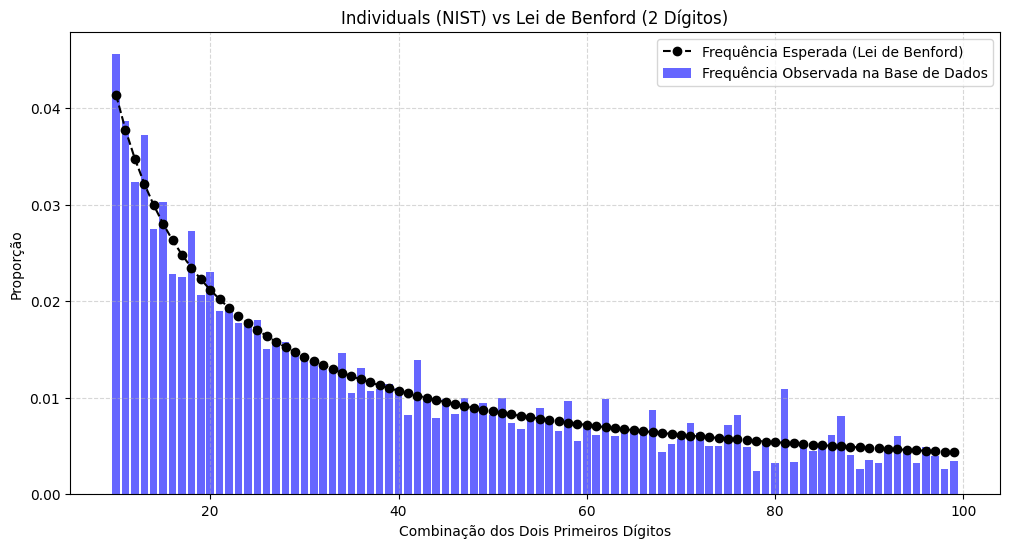


--- Métricas de Similaridade / Divergência ---
KL-Divergence: 0.014254
Jensen-Shannon Divergence: 0.003540
Hellinger Distance: 0.059633
Wasserstein Distance: 0.000579


In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy, wasserstein_distance
from scipy.spatial.distance import jensenshannon


def carregar_csv(caminho_arquivo):
    try:
        return pd.read_csv(caminho_arquivo)
    except Exception as e:
        print(f"Erro ao carregar CSV: {e}")
        return None

def carregar_dados():
    caminho_arquivo = "/content/drive/MyDrive/Boas bases de dados/individuals.csv"
    tipo_arquivo = "csv"

    if tipo_arquivo == "csv":
        df = carregar_csv(caminho_arquivo)
    else:
        print("Erro: Tipo de arquivo não suportado.")
        return None

    if df is not None:
        #print(df.head())
        return df


def processar_coluna(df):
    nome_coluna = "STATURE"

    if nome_coluna not in df.columns:
        print(f"Erro: A coluna '{nome_coluna}' não existe no DataFrame.")
        return None

    valores = df[nome_coluna].dropna()
    valores = pd.to_numeric(valores, errors='coerce')
    valores = valores.dropna()
    valores = valores[valores != 0]

    return valores.tolist()


def renormalizar(valores):
    renormalizados = []
    for divisor in range(1, 100):
        renormalizados.append([x / divisor for x in valores])
    return renormalizados

def elevar_potencia(valores_renormalizados):
    return [[x**13 for x in sublist] for sublist in valores_renormalizados]

def extrair_dois_primeiros_digitos(valores):
    digitos = []
    for valor in valores:
        try:
            if isinstance(valor, (float, int)):
                str_valor = str(abs(valor)).replace(".", "").lstrip("0")
                if len(str_valor) >= 2:
                    digitos.append(int(str_valor[:2]))
            else:
                str_valor = str(abs(float(valor))).replace(".", "").lstrip("0")
                if len(str_valor) >= 2:
                    digitos.append(int(str_valor[:2]))
        except ValueError:
            continue
    return digitos


def distrib_benford_dois_digitos():
    return {d: np.log10(1 + 1/d) for d in range(10, 100)}

def analisar_benford(digitos):
    contagem_real = {d: digitos.count(d) for d in range(10, 100)}

    total = len(digitos)
    proporcoes_reais = {d: contagem_real[d] / total for d in contagem_real if total > 0}

    proporcoes_esperadas = distrib_benford_dois_digitos()

    #print("\nComparação da Distribuição:")
    for d in range(10, 100):
        real = proporcoes_reais.get(d, 0)
        esperado = proporcoes_esperadas.get(d, 0)
        #print(f"Dígitos {d}: Real = {real:.4f}, Esperado = {esperado:.4f}")

    return proporcoes_reais, proporcoes_esperadas


def plotar_benford(proporcoes_reais, proporcoes_esperadas):
    digitos = list(proporcoes_esperadas.keys())
    reais = [proporcoes_reais.get(d, 0) for d in digitos]
    esperados = [proporcoes_esperadas[d] for d in digitos]

    plt.figure(figsize=(12, 6))
    plt.bar(digitos, reais, color="blue", alpha=0.6, label="Frequência Observada na Base de Dados")
    plt.plot(digitos, esperados, color="black", marker="o", linestyle="dashed", label="Frequência Esperada (Lei de Benford)")

    plt.xlabel("Combinação dos Dois Primeiros Dígitos")
    plt.ylabel("Proporção")
    plt.title("Individuals (NIST) vs Lei de Benford (2 Dígitos)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


def calcular_metricas_divergencia(proporcoes_reais, proporcoes_esperadas):
    digitos_ordenados = sorted(proporcoes_esperadas.keys())
    p = np.array([proporcoes_reais.get(d, 0) for d in digitos_ordenados])
    q = np.array([proporcoes_esperadas.get(d, 0) for d in digitos_ordenados])


    p /= p.sum()
    q /= q.sum()


    kl = entropy(p, q)


    js = jensenshannon(p, q) ** 2


    hellinger = np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))


    w_dist = wasserstein_distance(p, q)

    print("\n--- Métricas de Similaridade / Divergência ---")
    print(f"KL-Divergence: {kl:.6f}")
    print(f"Jensen-Shannon Divergence: {js:.6f}")
    print(f"Hellinger Distance: {hellinger:.6f}")
    print(f"Wasserstein Distance: {w_dist:.6f}")


df = carregar_dados()
if df is not None:
    valores_processados = processar_coluna(df)


    valores_renormalizados = renormalizar(valores_processados)
    valores_transformados = elevar_potencia(valores_renormalizados)


    valores_flat = [item for sublist in valores_transformados for item in sublist]


    digitos_extraidos = extrair_dois_primeiros_digitos(valores_flat)


    proporcoes_reais, proporcoes_esperadas = analisar_benford(digitos_extraidos)
    plotar_benford(proporcoes_reais, proporcoes_esperadas)


    calcular_metricas_divergencia(proporcoes_reais, proporcoes_esperadas)
